In [30]:
from json import loads
from pyspark.sql import SparkSession
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
from pyspark.sql.functions import col,from_json,udf,split,explode,lit,array
from pyspark.ml.feature import NGram
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,MapType,FloatType,ArrayType
import numpy as np
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score

In [2]:
spark = SparkSession.\
        builder.\
        appName("ml").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1024m").\
        getOrCreate()

22/12/10 08:41:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/10 08:41:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Load raw comment

In [ ]:
data = spark.read.parquet('hdfs://namenode:9000/TikiCleaned/Comment')
data.createOrReplaceTempView('data')
df = spark.sql("""
    select distinct clean_content,rating,sentiment,
    case
        when rating >= 4 then 2
        when rating = 3 then 1
        else 0
    end as label
    from data
    where clean_content <> '' and clean_content is not null and clean_content <> ' '
""")
df.toPandas().to_csv('data/data.csv',index=False)

# Load labeling comment

In [7]:
df = pd.read_csv('data/dataLabel.csv')

In [8]:
test = df[~pd.isna(df['true_label'])].reset_index(drop=True)
train = df[pd.isna(df['true_label'])].reset_index(drop=True)

In [9]:
test['true_label'] = test['true_label'].astype('int')

In [10]:
train = train.drop(columns=['true_label'])

In [11]:
df_test = spark.createDataFrame(test)
df_train = spark.createDataFrame(train)

In [10]:
df_test.write.partitionBy("label").mode('overwrite').parquet('hdfs://namenode:9000/ml/test_data')

In [11]:
df_train.write.partitionBy("label").mode('overwrite').parquet('hdfs://namenode:9000/ml/train_data')

22/12/08 15:07:42 WARN TaskSetManager: Stage 3 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.


## Lexicon-based sentiment analysis

In [12]:
df = df_train.withColumn('comment_term',split(df_train.clean_content, ' ', -1))
def getNGram(n):
    ngram = NGram(n=n)
    ngram.setInputCol("comment_term")
    ngram.setOutputCol("nGrams")
    df_nGram = ngram.transform(df)
    result_nGram = df_nGram.withColumn('word',explode(df_nGram.nGrams))\
        .groupBy(['label','word'])\
        .count()
    return result_nGram
result_nGram = getNGram(1)

In [15]:
for i in range(3):
    result_nGram.filter(result_nGram.label == i).orderBy(col("count").desc()).toPandas().to_csv(f'sample/{i}.csv',index=False)

22/12/08 15:11:03 WARN TaskSetManager: Stage 4 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 15:11:13 WARN TaskSetManager: Stage 9 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.
22/12/08 15:11:18 WARN TaskSetManager: Stage 14 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.


In [13]:
pst_word = {}
ngt_word = {}
with open('vi_sentiment/positive_words_vi.txt','r') as f:
    for line in f:
        line = line.replace('\n','')
        if line not in pst_word:
            pst_word[line] = 1
with open('vi_sentiment/negative_words_vi.txt','r') as f:
    for line in f:
        line = line.replace('\n','')
        if line not in pst_word:
            ngt_word[line] = 1

In [14]:
def check(sentent):
    list_token = sentent.split(' ')
    res = 0
    for token in list_token:
        if token in pst_word:
            res += 1
        elif token in ngt_word:
            res -= 1
    if res > 0:
        return 2
    elif res == 0:
        return 1
    else:
        return 0

In [15]:
def value_check(sentent):
    list_token = sentent.split(' ')
    pos = 0
    neg = 0
    for token in list_token:
        if token in pst_word:
            pos += 1
        elif token in ngt_word:
            neg += 1
    return round((pos - neg)/ (pos + neg + 1e-6),3)

In [16]:
spark.udf.register("check", check,IntegerType())
spark.udf.register("value_check", value_check,FloatType())

<function __main__.value_check(sentent)>

## Find Best Param

In [17]:
df_train.createOrReplaceTempView("train_data")

In [18]:
result_train = spark.sql("""
    select label,value_check(clean_content) score from train_data
""")

In [19]:
result_train = result_train.toPandas()

22/12/10 08:56:28 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
22/12/10 08:56:43 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
22/12/10 08:56:53 WARN TaskSetManager: Stage 0 contains a task of very large size (22337 KiB). The maximum recommended task size is 1000 KiB.


In [20]:
def f(row,val):
    if row['score'] > val:
        res = 2
    elif row['score'] < -val:
        res = 0
    else:
        res = 1
    return res

In [21]:
list_val = np.linspace(0,0.5,21)
list_acc = []
for val in list_val:
    result_train['prediction'] = result_train.apply(f,val=val,axis=1)
    list_acc.append(result_train[result_train['label']== result_train['prediction']].shape[0]*100/result_train.shape[0])

([<matplotlib.axis.XTick at 0x7f8cb8932e20>,
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.025'),
  Text(2, 0, '0.05'),
  Text(3, 0, '0.075'),
  Text(4, 0, '0.1'),
  Text(5, 0, '0.125'),
  Text(6, 0, '0.15'),
  Text(7, 0, '0.175'),
  Text(8, 0, '0.2'),
  Text(9, 0, '0.225'),
  Text(10, 0, '0.25'),
  Text(11, 0, '0.275'),
  Text(12, 0, '0.3'),
  Text(13, 0, '0.325'),
  Text(14, 0, '0.35'),
  Text(15, 0, '0.375'),
  Text(16, 0, '0.4'),
  Text(17, 0, '0.425'),
  Text(18, 0, '0.45'),
  Text(19, 0, '0.475'),
  Text(20, 0, '0.5')])

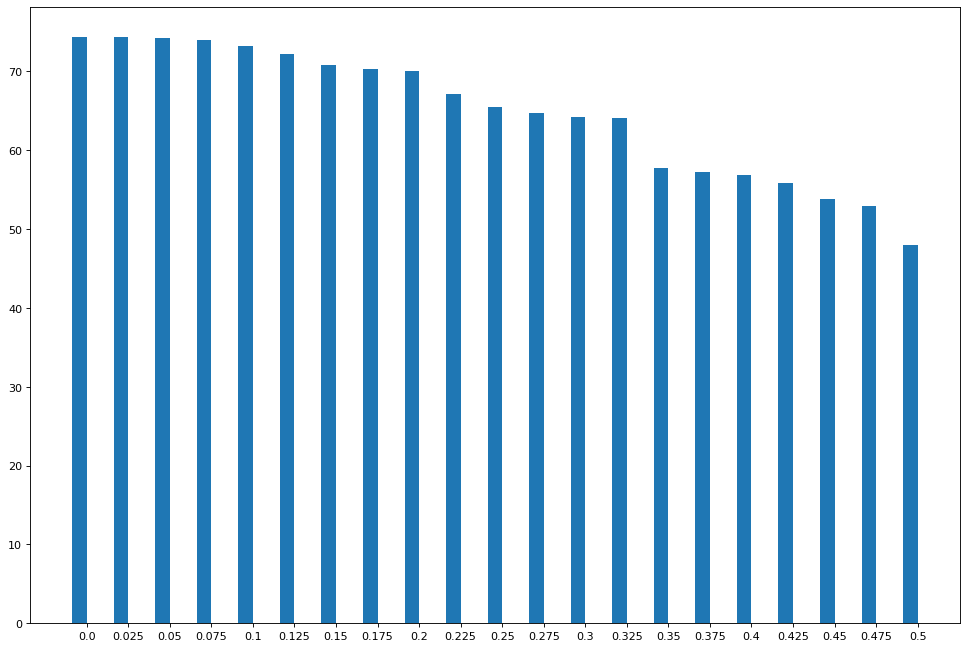

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)

labels = [str(round(x,3)) for x in list_val]
x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

plt.bar(x - width/2,width=width,height= list_acc)
plt.xticks(x,labels)

In [23]:
p_max = np.argmax(list_acc)

In [24]:
df_test.createOrReplaceTempView("test_data")

In [26]:
result_test = spark.sql("""
    select true_label,label,value_check(clean_content) score from test_data
""")

In [27]:
result_test =  result_test.toPandas()

In [28]:
result_test['prediction'] = result_test.apply(f,val=p_max,axis=1)

In [31]:
print(f'accuracy_score: ',accuracy_score(result_test.true_label, result_test.prediction))
print(f'prediction: ',precision_score(result_test.true_label, result_test.prediction, average='weighted'))
print(f'recall_score: ',recall_score(result_test.true_label, result_test.prediction, average='weighted'))
print(f'f1_score: ',f1_score(result_test.true_label, result_test.prediction, average='weighted'))

accuracy_score:  0.7217199115933293
prediction:  0.7081688945766338
recall_score:  0.7217199115933293
f1_score:  0.7142375841404099


In [32]:
print(classification_report(result_test.true_label, result_test.prediction))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46       805
           1       0.15      0.13      0.14       538
           2       0.84      0.87      0.86      3634

    accuracy                           0.72      4977
   macro avg       0.49      0.48      0.49      4977
weighted avg       0.71      0.72      0.71      4977

